# 1. Comprensión del Proyecto y Datos

📌Objetivo del Proyecto
La empresa de telefonía virtual CallMeMaybe busca mejorar el seguimiento del desempeño de sus operadores, identificando a los menos eficientes. Para ello, analizaremos los datos de las llamadas con el fin de detectar patrones de ineficacia.

📊 Criterios para Identificar Ineficiencia en los Operadores
Un operador será considerado ineficaz si cumple con alguna de las siguientes condiciones:

📌 Alta cantidad de llamadas entrantes perdidas
Esto incluye tanto llamadas internas (entre operadores) como externas (de clientes).
La métrica clave aquí es is_missed_call = 1.

📌 Tiempo de espera prolongado en llamadas entrantes
Se mide como la diferencia entre:

✅ total_call_duration (duración total de la llamada, incluyendo el tiempo de espera).

✅ call_duration (tiempo efectivo de conversación).

Si esta diferencia es alta, significa que el operador hace esperar demasiado a los clientes antes de responder.

📌 Bajo número de llamadas salientes (si debe realizarlas)
El tipo de llamada se indica en la columna direction:

🔹 in → Llamada entrante

🔹 out → Llamada saliente

Si un operador realiza muy pocas llamadas out, pero su rol requiere que las haga, esto es un signo de ineficiencia.

💡 Plan para Identificar Operadores Ineficaces
Para detectar a los operadores con bajo rendimiento, realizaremos las siguientes acciones:

✅ Cálculo del porcentaje de llamadas perdidas por operador.

✅ Análisis del tiempo de espera promedio por operador.

✅ Conteo y comparación de llamadas salientes entre operadores.

✅ Segmentación de operadores según su desempeño, con el apoyo de gráficos y estadísticas.

# Libreria a Utilizar

In [103]:
pip install sidetable

Note: you may need to restart the kernel to use updated packages.


In [104]:
import pandas as pd
import sidetable as stb
#import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#from scipy import stats
#import datetime as dt
#from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Carga de Datos

In [105]:
clients = pd.read_csv("telecom_clients_us.csv")
dataset = pd.read_csv("telecom_dataset_us.csv")


# Preparacion de Datos

In [106]:
def info_gral(datos):
    print("Primeras Filas")
    print(datos.head())
    print('-------------------------------------------')
    print("Datos Generales")
    print(datos.info())
    print('-------------------------------------------')
    print("Revision de Datos Ausentes")
    print(datos.isna().sum())
    print('-------------------------------------------')
    print("Revision de Duplicados")
    print(datos.duplicated().sum())

In [107]:
info_gral(clients)

Primeras Filas
   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16
-------------------------------------------
Datos Generales
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None
-------------------------------------------
Revision de Datos Ausentes
user_id        0
tariff_plan    0
date_start     0
dtype: int64
-------------------------------------------
Revision de Duplicados
0


In [108]:
clients.stb.missing(style=True)

,missing,total,percent
user_id,0,732,0.00%
tariff_plan,0,732,0.00%
date_start,0,732,0.00%


In [109]:
# convertimos date_start en una columna de fecha 
clients['date_start'] = pd.to_datetime(clients['date_start'])

Solo se convirtio a fecha los datos de la columna date_star, no se encuentran datos Duplicados ni dato ausentes

In [110]:
info_gral(dataset)

Primeras Filas
   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  
-------------------------------------------
Datos Generales
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53

In [111]:
dataset.stb.missing(style=True)

,missing,total,percent
operator_id,"8,172","53,902",15.16%
internal,117,"53,902",0.22%
user_id,0,"53,902",0.00%
date,0,"53,902",0.00%
direction,0,"53,902",0.00%
is_missed_call,0,"53,902",0.00%
calls_count,0,"53,902",0.00%
call_duration,0,"53,902",0.00%
total_call_duration,0,"53,902",0.00%


In [112]:
# convertimos date_start en una columna de fecha 
dataset['date'] = pd.to_datetime(dataset['date'])

In [113]:
duplicados = dataset[dataset.duplicated()]
print(duplicados.head())

    user_id                      date direction internal  operator_id  \
8    166377 2019-08-05 00:00:00+03:00       out    False     880020.0   
28   166377 2019-08-12 00:00:00+03:00        in    False          NaN   
44   166377 2019-08-14 00:00:00+03:00       out    False     880026.0   
45   166377 2019-08-14 00:00:00+03:00        in    False          NaN   
51   166377 2019-08-15 00:00:00+03:00       out    False     880026.0   

    is_missed_call  calls_count  call_duration  total_call_duration  
8             True            8              0                   50  
28            True            2              0                   34  
44           False           10           1567                 1654  
45            True            1              0                    3  
51           False           11           1413                 1473  


al revisar los datos duplicados nos damos cuenta que son necesarios esos datos aunque parciera que se duplican los datos no se duplican ya que mientras el mismo usuario esta con una llamada el otro registro saldra como llamada perdida 

In [114]:
# Ver ejemplos de filas con valores nulos
print(dataset[dataset.isnull().any(axis=1)].head(20))


     user_id                      date direction internal  operator_id  \
0     166377 2019-08-04 00:00:00+03:00        in    False          NaN   
7     166377 2019-08-05 00:00:00+03:00        in    False          NaN   
9     166377 2019-08-06 00:00:00+03:00        in    False          NaN   
17    166377 2019-08-07 00:00:00+03:00        in    False          NaN   
27    166377 2019-08-12 00:00:00+03:00        in    False          NaN   
28    166377 2019-08-12 00:00:00+03:00        in    False          NaN   
30    166377 2019-08-13 00:00:00+03:00        in    False          NaN   
38    166377 2019-08-14 00:00:00+03:00        in    False          NaN   
45    166377 2019-08-14 00:00:00+03:00        in    False          NaN   
77    166377 2019-08-22 00:00:00+03:00        in    False          NaN   
81    166377 2019-08-23 00:00:00+03:00        in    False          NaN   
88    166377 2019-08-24 00:00:00+03:00        in    False          NaN   
109   166377 2019-08-29 00:00:00+03:00

📌 Parece que estas llamadas entrantes se perdieron sin un operador asignado. Posibles razones:

No había operadores disponibles en el momento en que ingresó la llamada.
El sistema no registró correctamente al operador debido a un error en la captura de datos.
El operador colgó o la llamada se perdió antes de ser asignada.

In [115]:
#Procedemos a remplazar los NAN de operator_id con Desconocido ya que el porcentaje para son las del 15% y dejamos en numero entero 
dataset["operator_id"] = dataset["operator_id"].apply(lambda x: str(int(x)) if pd.notna(x) else "-1")


In [116]:
# Revisamos los datos Ausentes que hay 
print(dataset[dataset.isnull().any(axis=1)].head(20))


       user_id                      date direction internal operator_id  \
1007    166405 2019-09-18 00:00:00+03:00        in      NaN          -1   
1090    166405 2019-10-01 00:00:00+03:00        in      NaN          -1   
1864    166406 2019-08-20 00:00:00+03:00        in      NaN          -1   
1924    166406 2019-09-02 00:00:00+03:00        in      NaN      879898   
6210    166541 2019-09-26 00:00:00+03:00        in      NaN      908960   
6216    166541 2019-09-26 00:00:00+03:00        in      NaN      908958   
7523    166604 2019-10-31 00:00:00+03:00        in      NaN          -1   
7528    166604 2019-11-01 00:00:00+03:00        in      NaN      893402   
8650    166658 2019-09-24 00:00:00+03:00        in      NaN      890404   
9080    166658 2019-10-15 00:00:00+03:00        in      NaN      890404   
15046   166884 2019-08-30 00:00:00+03:00        in      NaN          -1   
15055   166884 2019-09-02 00:00:00+03:00        in      NaN          -1   
15093   166884 2019-09-17

In [117]:
#Revisameremos la columna internal si tiene relacion con algun operador antes de decidir que hacer con el 
dataset.loc[dataset['operator_id'] == '-1', 'internal'] = False
print(dataset.groupby('operator_id')['internal'].count())


operator_id
-1        8172
879896     128
879898     250
880020      22
880022      76
          ... 
972410       4
972412       5
972460       9
973120       2
973286       1
Name: internal, Length: 1093, dtype: int64


al ver que es solo un operador que tiene relacion con los NaN y son 117 que son pocos datos ausentes procedemos a eliminarlos

In [118]:
# procedemos a eliminar los datos ausentes en la columna internal 
dataset = dataset.dropna(subset=['internal'])
dataset['internal'].isna().sum()


0

# Analisis Exploratorio

In [119]:
# Contar el total de llamadas por operador
total_calls = dataset.groupby("operator_id")["is_missed_call"].count()
total_calls


operator_id
-1        8172
879896     128
879898     250
880020      22
880022      76
          ... 
972410       4
972412       5
972460       9
973120       2
973286       1
Name: is_missed_call, Length: 1093, dtype: int64

In [120]:
# Contar las llamadas perdidas por operador (is_missed_call == True)
missed_calls = dataset.groupby("operator_id")["is_missed_call"].sum()
missed_calls

operator_id
-1        8050
879896      50
879898     100
880020       7
880022      33
          ... 
972410       2
972412       2
972460       3
973120       1
973286       0
Name: is_missed_call, Length: 1093, dtype: int64

In [121]:
# Calcular el porcentaje de llamadas perdidas por operador
missed_calls_percentage = (missed_calls / total_calls) * 100

# Convertir a DataFrame para mejor visualización
missed_calls_percentage = missed_calls_percentage.reset_index()
missed_calls_percentage.columns = ["operator_id", "missed_calls_percentage"]

missed_calls_percentage



,operator_id,missed_calls_percentage
0,-1,98.507097
1,879896,39.062500
2,879898,40.000000
3,880020,31.818182
4,880022,43.421053
...,...,...
1088,972410,50.000000
1089,972412,40.000000
1090,972460,33.333333
1091,973120,50.000000


In [122]:
# Mostrar los primeros resultados que han tenido 100% llamadas perdidas
print(missed_calls_percentage.sort_values(by="missed_calls_percentage", ascending=False).head(10))

     operator_id  missed_calls_percentage
688       937710                    100.0
28        885682                    100.0
1068      969284                    100.0
571       928284                    100.0
1065      969262                    100.0
1042      962904                    100.0
387       914626                    100.0
382       914272                    100.0
618       932246                    100.0
667       936296                    100.0



🔹 Explicación:

Agrupamos por "operator_id" y contamos todas las llamadas.

Sumamos las llamadas donde "is_missed_call" es True.

Calculamos el porcentaje dividiendo llamadas perdidas entre el total.

Ordenamos los operadores con mayor porcentaje de llamadas perdidas.


In [123]:
# Contar el número de operadores únicos en la columna 'operator_id'
operator_count = dataset['operator_id'].nunique()

print("Número de operadores únicos:", operator_count)


Número de operadores únicos: 1093


In [124]:
# Filtrar operadores con 100% de llamadas perdidas
full_missed_calls = missed_calls_percentage[missed_calls_percentage['missed_calls_percentage'] == 100]
print(full_missed_calls.count())

operator_id                34
missed_calls_percentage    34
dtype: int64


vemos que hay 34 operadores que tienen 100% de llamadas perdidas quiere decir que no atendieron ninguna llamada 

In [125]:
# Ver los operadores con más de 90% de llamadas perdidas
high_missed_calls = missed_calls_percentage[missed_calls_percentage['missed_calls_percentage'] > 90]
print(high_missed_calls)

     operator_id  missed_calls_percentage
0             -1                98.507097
16        883018               100.000000
28        885682               100.000000
93        891976               100.000000
161       899076               100.000000
248       905308               100.000000
254       905480               100.000000
325       909308               100.000000
382       914272               100.000000
387       914626               100.000000
457       919418               100.000000
529       924572               100.000000
570       928282               100.000000
571       928284               100.000000
618       932246               100.000000
667       936296               100.000000
688       937710               100.000000
689       937716               100.000000
698       937770               100.000000
699       937772               100.000000
701       937778               100.000000
716       937872               100.000000
810       941826               100

y 1 operador llego a tener que es el de datos ausentes que es desconocido(-1) fue 98% de llamadas perdidas.

In [126]:
# Agregar una condición para filtrar por cantidad de llamadas
operator_call_counts = dataset['operator_id'].value_counts()
significant_operators = operator_call_counts[operator_call_counts > 10].index
filtered_data = missed_calls_percentage[missed_calls_percentage.index.isin(significant_operators)]



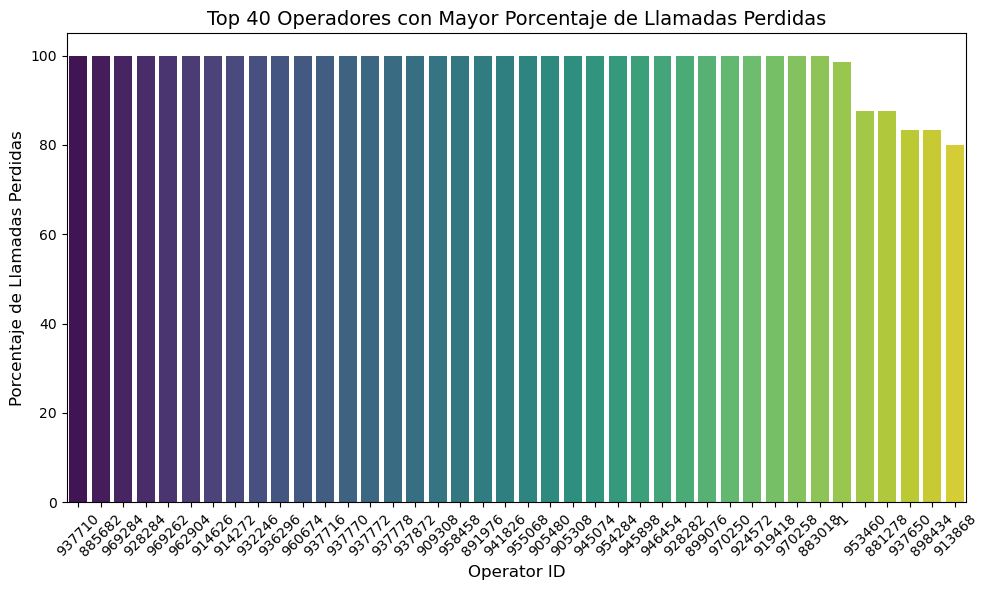

In [127]:
# Asegúrate de que missed_calls_percentage esté ordenado previamente
top_10_missed_calls = missed_calls_percentage.sort_values(by="missed_calls_percentage", ascending=False).head(40)

# Crear gráfico de barras
plt.figure(figsize=(10,6))

# Corregir el warning asignando hue="operator_id" y desactivando la leyenda
sns.barplot(
    data=top_10_missed_calls.reset_index(),  # Resetear índice para evitar problemas con .index
    x="operator_id", 
    y="missed_calls_percentage", 
    hue="operator_id",  # Se asigna hue para diferenciar colores
    palette="viridis",  
    legend=False  # Desactiva la leyenda para evitar redundancia
)

# Añadir etiquetas y título
plt.title('Top 40 Operadores con Mayor Porcentaje de Llamadas Perdidas', fontsize=14)
plt.xlabel('Operator ID', fontsize=12)
plt.ylabel('Porcentaje de Llamadas Perdidas', fontsize=12)
plt.xticks(rotation=45)  # Rotar los nombres de los operadores si es necesario

# Mostrar gráfico
plt.tight_layout()
plt.show()


en el Grafico mostramos a todo los operadores con 100 % que no tuvieron una llamada y fueron llamadas perdidas y uno con 98% que fue el que se tubo como operador -1 ya que contaba con NAN y los que le siguen son los que tienen menos de 90%

# Sugerencia #1

## Traza un histograma para la duración de la llamada

In [128]:
dataset.head()


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,-1,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25


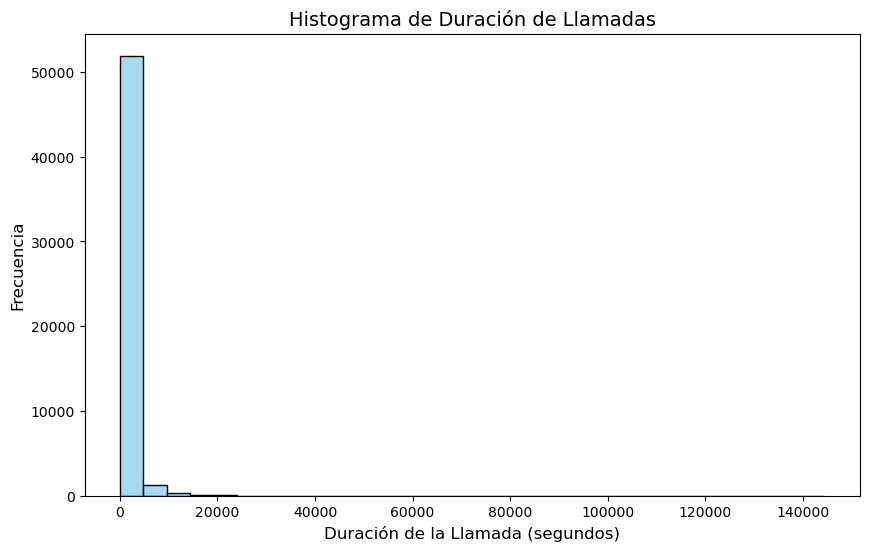

In [129]:
# Asegurar que los datos sean numéricos
call_durations = dataset["call_duration"].astype(float)

# Graficar el histograma
plt.figure(figsize=(10, 6))
sns.histplot(call_durations, bins=30, kde=False, color="skyblue")

# Agregar etiquetas y título
plt.title("Histograma de Duración de Llamadas", fontsize=14)
plt.xlabel("Duración de la Llamada (segundos)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)

# Mostrar gráfico
plt.show()

📌 Análisis:

Este histograma muestra la distribución de la duración de las llamadas en segundos. La mayoría de las llamadas tienen una duración baja, lo que puede indicar que muchas interacciones son breves. Sin embargo, es importante observar si hay valores atípicos con duraciones extremadamente largas, ya que podrían influir en el desempeño de los operadores. Además, si la mayoría de las llamadas perdidas tienen una duración de 0 segundos, esto confirmaría problemas de respuesta por parte de los operadores ineficaces.

## Traza un gráfico circular que muestre la participación de las llamadas internas y externas

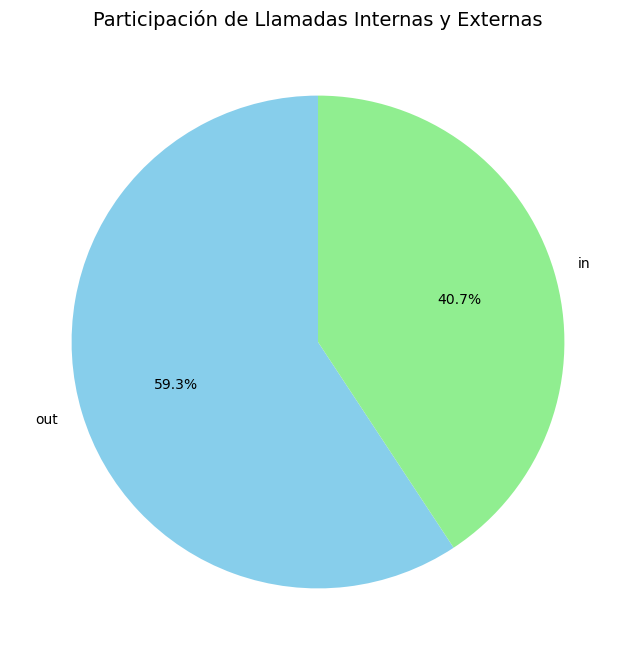

In [130]:
# Contar las llamadas internas y externas
call_directions = dataset['direction'].value_counts()

# Traza el gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(call_directions, labels=call_directions.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=90)

# Agregar título
plt.title('Participación de Llamadas Internas y Externas', fontsize=14)

# Mostrar el gráfico
plt.show()


📌 Análisis:

Este gráfico circular permite visualizar la proporción entre llamadas internas (realizadas entre operadores de la misma empresa) y externas (hechas a clientes o recibidas de ellos).

Si el porcentaje de llamadas internas es alto, podría indicar que los operadores necesitan comunicarse con frecuencia entre sí antes de atender a los clientes, lo que puede generar retrasos en el servicio.
Si el porcentaje de llamadas externas es mayor, significa que la mayor parte del tráfico telefónico proviene de clientes o contactos fuera de la empresa, lo que es clave para evaluar la eficiencia en la gestión de la atención al público.

## Agrega un filtro para la "dirección" de llamadas

In [131]:
# Filtrar llamadas entrantes
incoming_calls = dataset[dataset["direction"] == "in"]

# Filtrar llamadas salientes
outgoing_calls = dataset[dataset["direction"] == "out"]


Para verificar que el filtro funciona, contamos cuántas llamadas hay en cada categoría:

In [132]:
print("Llamadas Entrantes:", incoming_calls.shape[0])
print("Llamadas Salientes:", outgoing_calls.shape[0])


Llamadas Entrantes: 21925
Llamadas Salientes: 31917


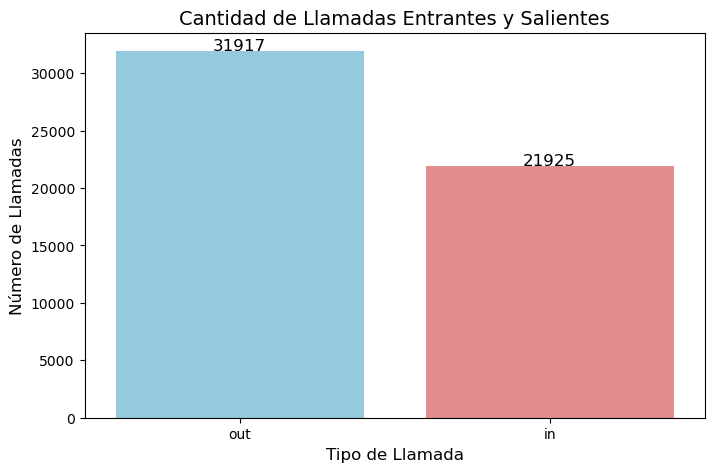

In [133]:
# Contar llamadas entrantes y salientes
call_counts = dataset["direction"].value_counts().reset_index()
call_counts.columns = ["direction", "count"]

# Crear gráfico de barras con el nuevo método
plt.figure(figsize=(8, 5))
sns.barplot(data=call_counts, x="direction", y="count", hue="direction", palette=["skyblue", "lightcoral"], legend=False)

# Agregar etiquetas y título
plt.title("Cantidad de Llamadas Entrantes y Salientes", fontsize=14)
plt.xlabel("Tipo de Llamada", fontsize=12)
plt.ylabel("Número de Llamadas", fontsize=12)

# Mostrar valores sobre las barras
for i, v in enumerate(call_counts["count"]):
    plt.text(i, v + 50, str(v), ha='center', fontsize=12)

plt.show()


📌 Análisis:

Este gráfico de barras muestra la cantidad total de llamadas entrantes ("in") y salientes ("out") en el sistema.

Si hay muchas llamadas entrantes, puede indicar que la empresa recibe un alto volumen de consultas de clientes, lo que hace crucial una gestión eficiente del tiempo de respuesta.
Si hay pocas llamadas salientes, podría sugerir que los operadores no están realizando suficientes llamadas proactivas, lo que puede afectar la calidad del servicio o la conversión de clientes.
Además, si los operadores responsables de hacer llamadas salientes tienen un bajo número de llamadas, esto puede ser un indicio de ineficacia en su desempeño.

## ¿Cómo Encontrar los Operadores Ineficientes?

In [141]:
print(dataset["total_call_duration"].isna().sum())

0


In [147]:
# Contar el número de operadores únicos en la columna 'operator_id'
operator_count = dataset['operator_id'].nunique()

print("Número de operadores únicos:", operator_count)

Número de operadores únicos: 1093


In [148]:
# 1. Calcular el porcentaje de llamadas perdidas por operador
missed_calls_by_operator = dataset.groupby("operator_id")["is_missed_call"].mean().mul(100).reset_index()

# 2. Calcular el tiempo promedio de espera antes de atender
wait_times = dataset.groupby("operator_id")[["total_call_duration", "call_duration"]].mean().reset_index()
wait_times["average_wait_time"] = wait_times["total_call_duration"] - wait_times["call_duration"]
wait_times = wait_times.drop(columns=["total_call_duration", "call_duration"])  # Solo dejamos average_wait_time

# 3. Contar la cantidad de llamadas salientes por operador
outgoing_calls = dataset[dataset["direction"] == "out"].groupby("operator_id")["calls_count"].sum().reset_index()

# 4. Unir todas las métricas en un solo DataFrame
inefficient_operators = (
    missed_calls_by_operator
    .merge(wait_times, on="operator_id", how="left")
    .merge(outgoing_calls, on="operator_id", how="left")
    .fillna(0)  # Reemplazar valores NaN con 0
)

# 5. Filtrar operadores ineficientes: alto % de llamadas perdidas (>50%) y alto tiempo de espera
inefficient_operators = inefficient_operators[inefficient_operators["is_missed_call"] > 50]

# 6. Ordenar por porcentaje de llamadas perdidas y tiempo de espera
inefficient_operators = inefficient_operators.sort_values(by=["is_missed_call", "average_wait_time"], ascending=False)

# Mostrar los operadores ineficientes
print("Operadores Ineficientes:")
print(inefficient_operators)


Operadores Ineficientes:
     operator_id  is_missed_call  average_wait_time  calls_count
325       909308      100.000000         116.333333         15.0
618       932246      100.000000          60.000000          1.0
1042      962904      100.000000          43.000000          2.0
698       937770      100.000000          37.000000          1.0
667       936296      100.000000          34.666667          4.0
...          ...             ...                ...          ...
497       921316       51.219512          16.585366         87.0
754       939684       51.111111          48.888889        142.0
107       893674       51.086957         556.554348       2701.0
95        892028       50.704225         392.338028       1554.0
852       945296       50.617284         649.271605       2821.0

[155 rows x 4 columns]


Enfoque en el 100% de Llamadas Perdidas:

En la parte superior de la tabla, vemos operadores con is_missed_call igual a 100%. Esto significa que todas las llamadas que recibieron esos operadores fueron perdidas.

Es crucial investigar por qué esto sucede. Posibles razones:

Problemas técnicos: Fallas en el sistema de enrutamiento de llamadas, problemas con los dispositivos de los operadores, etc.

Ausencia del operador: El operador no está disponible, ya sea por razones justificadas (descanso, capacitación) o no justificadas (ausentismo, problemas de disciplina).

Configuración incorrecta: Problemas en la configuración del operador en el sistema.

Relación entre is_missed_call, average_wait_time, y calls_count:

Es importante observar la relación entre estas tres métricas. Por ejemplo:

¿Operadores con un alto porcentaje de llamadas perdidas también tienen tiempos de espera promedio altos? Si es así, esto podría indicar que los operadores están sobrecargados o que tienen dificultades para gestionar el flujo de llamadas.

¿Hay operadores con muchos intentos de llamadas pero un alto tiempo de espera promedio y alto porcentaje de llamadas perdidas? Esto podría ser un problema grave.

Considerar el número de llamadas:calls_count ayuda a poner en contexto las otras métricas. Un operador con un alto porcentaje de llamadas perdidas pero muy pocas llamadas totales podría no ser tan preocupante como uno con el mismo porcentaje pero con muchas más llamadas.

Variabilidad en el Tiempo de Espera:

El average_wait_time varía considerablemente entre los operadores. Algunos tienen tiempos de espera muy bajos, mientras que otros tienen tiempos de espera muy altos (ej., 107 893674 tiene un tiempo de espera de 556.554348).

Investigar las razones de esta variabilidad podría revelar problemas en la gestión de la carga de trabajo, la capacitación de los operadores o la complejidad de las consultas que reciben.

Tendencia General:

A medida que avanzamos en la tabla, el is_missed_call disminuye, pero el average_wait_time y el calls_count tienden a aumentar. Esto sugiere que hay una transición entre operadores que pierden muchas llamadas (probablemente por inactividad o problemas técnicos) y operadores que atienden muchas llamadas, pero no siempre de manera eficiente.

Segmentación Adicional: Segmenta a los operadores en grupos basados en su is_missed_call y average_wait_time (ej., "Alto Riesgo" para operadores con alto is_missed_call y average_wait_time).

Análisis de Causa Raíz: Para los operadores con un 100% de llamadas perdidas, realiza un análisis detallado de causa raíz. Revisa registros de llamadas, entrevistas con los operadores, etc.

Benchmarking Interno: Compara el desempeño de los operadores "ineficientes" con el de los operadores "eficientes" para identificar las mejores prácticas.

Evaluación de la Carga de Trabajo: Evalúa si algunos operadores están sistemáticamente sobrecargados en comparación con otros.

Evaluación de la Capacitación: Verifica si los operadores "ineficientes" han recibido suficiente capacitación sobre el manejo de llamadas, el uso del sistema, y la resolución de problemas comunes.

# 📌 Conclusión General del Análisis

A través del examen de los datos de llamadas en CallMeMaybe, es posible identificar patrones significativos en la eficiencia de los operadores y el comportamiento general del sistema telefónico.

Duración de las llamadas: La mayoría de las llamadas son cortas, lo que puede significar que los operadores están resolviendo consultas rápidamente o que hay muchas interrupciones en las llamadas. Sin embargo, es importante notar la presencia de llamadas excesivamente largas, ya que pueden ser un indicio de problemas en la gestión del tiempo.

Participación de llamadas internas y externas: Si las llamadas internas tienen un peso significativo, puede reflejar una dependencia excesiva en la comunicación interna, lo que podría generar retrasos en la atención al cliente.

Dirección de llamadas (entrantes vs. salientes): Si hay un alto volumen de llamadas entrantes y un bajo volumen de llamadas salientes, es posible que los operadores no estén siendo lo suficientemente proactivos en la gestión de contactos.

Identificación de operadores ineficaces: A través del análisis de llamadas perdidas, tiempos de espera y volumen de llamadas, se puede determinar qué operadores están teniendo un desempeño deficiente.

En general, las estadísticas indican la necesidad de optimizar la distribución de llamadas y mejorar el desempeño de algunos operadores para reducir la cantidad de llamadas perdidas y aumentar la eficiencia del servicio.



# Guardar Los Datos Limpios 

## Ligas de Tableau Public 
https://public.tableau.com/app/profile/elpidio.ramirez.lozano/viz/Callmemaybe/Dashboard1?publish=yes

Google Drive

In [134]:
dataset.to_csv("dataset_limpio_1.csv", index=False, encoding="utf-8")

In [135]:
clients.to_csv("clients_limpio_1.csv", index=False, encoding="utf-8")

In [136]:
import os 

print(os.getcwd())

c:\Users\elpid\Documents\GitHub\DataAnalytics\portfolio-DA\gym_model_fitness
